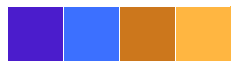

In [122]:
import os
import math


import IPython
from functools import lru_cache
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from pypeg2 import *

import beoid.filename_parser
from beoid.gaze import *

import matplotlib
matplotlib.rcParams['figure.figsize'] = 5, 10

def display_full(x):
    pd.set_option('display.max_rows', len(x))
    IPython.display.display(x)
    pd.reset_option('display.max_rows')
    
# C1_dark, C1_light, C2_dark, C2_light
palette = sns.color_palette(["#4B1CCC", "#3C70FF", "#CC771C", "#FFB641"])
sns.set_palette(palette)
sns.palplot(palette)

In [64]:
attention_maps = pd.read_pickle('../attention-maps-beoid-with-metadata.pickle')
shifted_valid_gaze = pd.read_pickle('../beoid-gaze-valid-shifted.pickle')

<IPython.core.display.Javascript object>


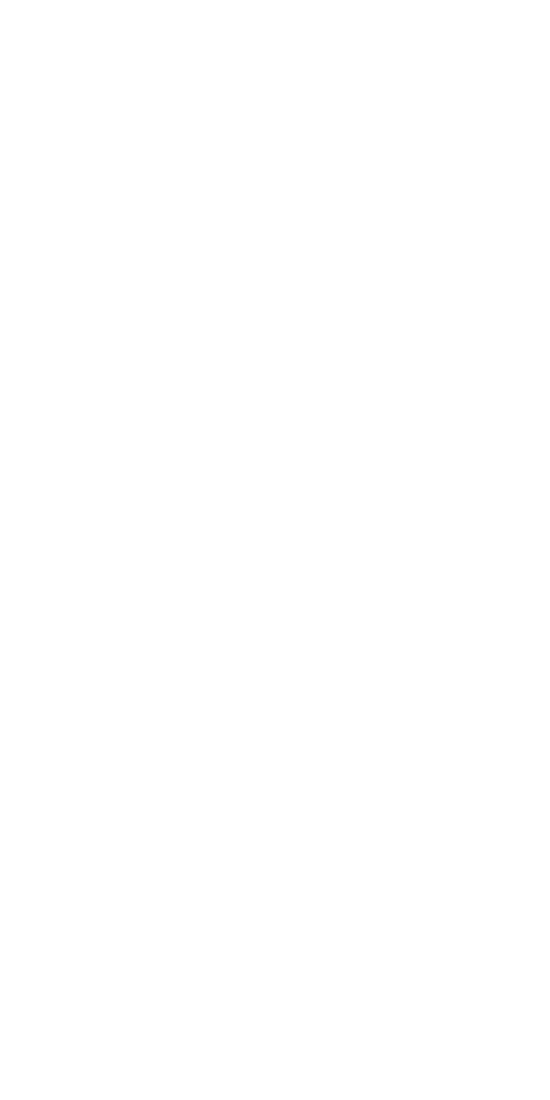

In [65]:
from scipy.signal import argrelmax

#TODO: Currently in the processof figuring out how to take the extrema values,
# order them by decreasing value, then take the top n
def peak_locations(attention_map, top_n=5):
    shape = attention_map.shape
    order = 1
    # argrelmax only looks for maxima across a single axis/dimension
    # so we have to look in both the X and Y directions for maxima,
    # then find where they both peak
    maxima_x_idx = argrelmax(attention_map, axis=0, order=order, mode='wrap')
    maxima_y_idx = argrelmax(attention_map, axis=1, order=order, mode='wrap')
    maxima_idx_pairs = set(zip(maxima_x_idx[0], maxima_x_idx[1])) & set(zip(maxima_y_idx[0], maxima_y_idx[1]))
    maxima_idx = (np.array(list(map(lambda x: x[0], maxima_idx_pairs))), np.array(list(map(lambda x: x[1], maxima_idx_pairs))))
    maxima_values = attention_map[maxima_idx]
    top_n_maxima_idx = maxima_values.argsort()[::-1][:top_n]
    return (maxima_idx[0][top_n_maxima_idx], maxima_idx[1][top_n_maxima_idx])

def scale_locations(src_shape, dest_shape, locations):
    assert(len(src_shape) == 2)
    assert(len(dest_shape) == 2)
    f1 = lambda x: int(x * dest_shape[0] / src_shape[0])
    f2 = lambda x: int(x * dest_shape[1] / src_shape[1])
    return (list(map(f1, locations[0])), list(map(f2, locations[1])))

attention_map = attention_maps['Attention Map'].iloc[0]
slice_max_idx = peak_locations(attention_map)

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x_bounds = range(0, 28)
y_bounds = x_bounds
ax.plot_wireframe(*np.meshgrid(x_bounds, y_bounds), attention_map, cmap='viridis', rstride=1, cstride=1)
ax.scatter(slice_max_idx[1], slice_max_idx[0], attention_map[slice_max_idx], c='yellow', depthshade=False, s=100)
%matplotlib inline

In [66]:
from IPython.display import display, HTML
attention_map_with_gaze = pd.merge(attention_maps, shifted_valid_gaze, 
                                   left_on=['Video frame', 'Video'], 
                                   right_on=['frame', 'Video'],
                                   how='inner')
attention_map_with_gaze.drop(['camera_3d_' + dim for dim in list('xyz')] + 
                             ['gaze_3d_' + dim for dim in list('xyz')] + 
                             ['fixation_' + str(period) for period in [3, 5, 9]] + 
                             ['time', 'frame'], axis=1, inplace=True)
attention_map_with_gaze.sort_values(['Network', 'EBP Type', 'Clip', 'Frame'], inplace=True)
attention_map_with_gaze.groupby(['Network', 'EBP Type', 'Clip']).count()

Attention Map  \
Network  EBP Type        Clip                                                      
Spatial  Contrastive     00_Desk2_pick-up_plug_334-366                        32   
                         00_Desk2_pick-up_tape_1070-1099                      25   
                         00_Printer1_pull_drawer_173-220                      47   
                         00_Sink1_open_jar_1890-1938                          30   
                         00_Sink1_take_cup_1151-1188                          14   
                         00_Sink1_turn_tap_694-717                            23   
                         00_Sink2_pick-up_jar_1443-1471                        3   
                         00_Sink2_put_jar_1620-1659                           35   
                         01_Desk2_pick-up_tape_957-998                        37   
                         01_Desk2_switch-on_socket_736-785                    40   
                         01_Door2_scan_card-reader_79-125                     30   
                         01_Sink1_put_cup_520-569                              6   
                         01_Sink1_put_cup_799-826                             26   
                         01_Sink1_turn_tap_406-441                            35   
                         01_Sink2_pick-up_cup_156-181                          2   
                         01_Sink2_press_button_527-561                        34   
                         01_Sink2_put_jar_924-952                             18   
                         02_Desk1_place_tape_1258-1303                        14   
                         02_Desk1_plug_plug_437-519                           75   
                         02_Desk2_switch-on_socket_625-676                    38   
                         02_Door2_open_door_181-224                           13   
                         02_Printer1_press_button_447-485                     38   
                         02_Sink1_press_button_524-552                        16   
                         02_Sink1_put_cup_472-524                             31   
                         02_Sink1_rinse_cup_232-308                           28   
                         02_Sink1_scoop_spoon_1294-1332                       25   
                         02_Sink2_open_jar_1226-1252                          25   
                         02_Sink2_pick-up_jar_1003-1027                        3   
                         02_Sink2_pour_spoon_1319-1333                        14   
                         03_Desk1_insert_wire_429-509                         80   
...                                                                          ...   
Temporal Non-Contrastive 05_Treadmill1_press_button_4851-4867                  7   
                         05_Treadmill1_press_button_4879-4892                  4   
                         05_Treadmill2_press_button_2501-2518                  8   
                         05_Treadmill2_press_button_2966-2985                  8   
                         05_Treadmill2_press_button_4027-4056                 20   
                         05_Treadmill2_press_button_5008-5036                 19   
                         05_Treadmill3_press_button_203-221                    9   
                         05_Treadmill3_press_button_2298-2308                  1   
                         05_Treadmill3_press_button_2354-2370                  7   
                         05_Treadmill3_press_button_2370-2385                  6   
                         05_Treadmill3_press_button_2650-2667                  8   
                         05_Treadmill3_press_button_3775-3786                  2   
                         06_Row3_insert_weight-pin_407-450                    15   
                         06_Treadmill1_hold-down_button_331-528              155   
                         06_Treadmill1_press_button_1822-1835                  4   
                         06_Treadmi

In [67]:
frame_size = (640, 480)
frame_centre = (frame_size[0]/2, frame_size[1]/2)

def pair_euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def distance_from_frame_center(row):
    gaze_2d_x = row['gaze_2d_x']
    gaze_2d_y = row['gaze_2d_y']
    return pair_euclidean_distance((gaze_2d_x, gaze_2d_y), frame_centre)
    
spatial_contrastive = attention_map_with_gaze[(attention_map_with_gaze['Network'] == 'Spatial') & \
                        (attention_map_with_gaze['EBP Type'] == 'Contrastive')]
clip_gaze = spatial_contrastive.drop(['Attention Map', 'Network', 'EBP Type', 'Window Size'], axis=1)
clip_gaze_from_frame_centre = clip_gaze.copy()
clip_gaze_from_frame_centre['Gaze Distance'] = clip_gaze.apply(distance_from_frame_center, axis=1)
clip_gaze_from_frame_centre.describe()

,Frame,Video frame,Operator,gaze_2d_x,gaze_2d_y,Gaze Distance
count,3758.000000,3758.000000,3758.000000,3758.000000,3758.000000,3758.000000
mean,37.880788,1265.473656,3.973390,255.092491,274.441786,119.758780
std,33.045563,1311.150672,1.796052,61.529945,89.807762,53.907733
min,1.000000,80.000000,0.000000,41.120000,4.320000,6.400195
25%,12.000000,394.250000,3.000000,221.132500,201.995000,77.441231
50%,28.000000,676.500000,4.000000,257.630000,263.525000,118.083258
75%,55.000000,1794.000000,5.000000,292.510000,350.865000,158.297622
max,164.000000,5036.000000,7.000000,475.660000,461.870000,303.748391


# Compare the operators' gaze  to the attention map's peak

Now we have the attention maps peaks and operator's gaze combined its time to compare them

In [123]:
video_shape = (640, 480)

def first(pair):
    return pair[0]

def second(pair):
    return pair[1]

def np_to_pairs(xs, ys):
    """
    >>> np_to_pairs(np.array([1, 3]), np.array([2, 4]))
    [(1, 2), (3, 4)]
    """
    return list(zip(xs, ys))


def pairs_to_np(pairs):
    """
    >>> pairs_to_np([(1, 2), (3, 4)])
    (array([1, 3]), array([2, 4]))
    """
    xs = np.array([first(pair) for pair in pairs])
    ys = np.array([second(pair) for pair in pairs])
    return (xs, ys)

max_dist = math.sqrt(first(video_shape)**2 + second(video_shape)**2)
def compare_gaze(row):
    attention_map = row['Attention Map']
    peak_idx = peak_locations(attention_map, top_n=1)
    scaled_peak_idx = scale_locations(attention_map.shape, video_shape, peak_idx)
    gaze_2d_x = row['gaze_2d_x']
    gaze_2d_y = row['gaze_2d_y']
    def distance_to_gaze(peak):
        return math.sqrt((gaze_2d_x - first(peak))**2 + (gaze_2d_y - second(peak))**2)
    return list(map(distance_to_gaze, np_to_pairs(*scaled_peak_idx)))
    
distances = attention_map_with_gaze.apply(compare_gaze, axis=1)
min_distances = distances.apply(min)
attention_map_with_gaze['Gaze Distance'] = min_distances

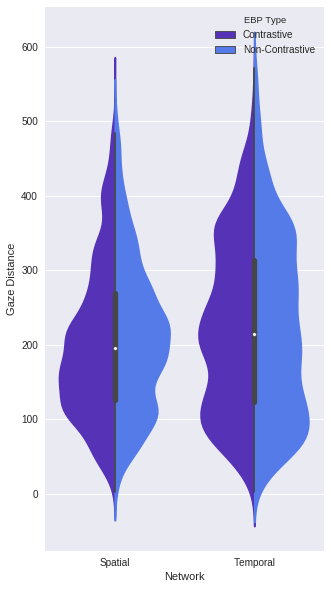

In [139]:
sns.violinplot(x='Network', y='Gaze Distance', hue='EBP Type',  split=True, data=attention_map_with_gaze)

So this violin plot is kind of hard to understand, lets instead look at what percentage of attention map peaks fall within X pixels of the gaze centre using a cumulative frequency plot

(0, 600)

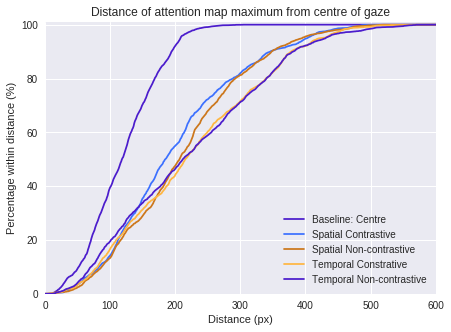

In [125]:
gaze_distances = attention_map_with_gaze['Gaze Distance']
upper_limits = np.arange(0, max_dist, 1)

spatial_contrastive_distances = attention_map_with_gaze[(attention_map_with_gaze['Network'] == 'Spatial') & \
                       (attention_map_with_gaze['EBP Type'] == 'Contrastive')]['Gaze Distance']
spatial_non_contrastive_distances = attention_map_with_gaze[(attention_map_with_gaze['Network'] == 'Spatial') & \
                                               (attention_map_with_gaze['EBP Type'] == 'Non-Contrastive')]['Gaze Distance']
temporal_contrastive_distances = attention_map_with_gaze[(attention_map_with_gaze['Network'] == 'Temporal') & \
                                               (attention_map_with_gaze['EBP Type'] == 'Contrastive')]['Gaze Distance']
temporal_non_contrastive_distances = attention_map_with_gaze[(attention_map_with_gaze['Network'] == 'Temporal') & \
                                               (attention_map_with_gaze['EBP Type'] == 'Non-Contrastive')]['Gaze Distance']


def count_distances_under_limit(distances, upper_limit):
    return np.sum(distances < upper_limit)

def plt_distance_cum(ax, distances, **kwargs):
    cumulative_frequencies = np.array(list(map(lambda upper_limit: count_distances_under_limit(distances, upper_limit),
                                             upper_limits)), dtype=np.float64)
    cumulative_frequencies /= cumulative_frequencies.max()
    cumulative_frequencies *= 100
    ax.plot(upper_limits, cumulative_frequencies, **kwargs)
    ax.set_ylim(0, 101)

    
fig, ax = plt.subplots(figsize=(7, 5))

plt_distance_cum(ax, clip_gaze_from_frame_centre['Gaze Distance'], label='Baseline: Centre')
plt_distance_cum(ax, spatial_contrastive_distances, label='Spatial Contrastive')
plt_distance_cum(ax, spatial_non_contrastive_distances, label='Spatial Non-contrastive')
plt_distance_cum(ax, temporal_contrastive_distances, label='Temporal Constrative')
plt_distance_cum(ax, temporal_non_contrastive_distances, label='Temporal Non-contrastive')
plt.legend(loc='lower right')
plt.title("Distance of attention map maximum from centre of gaze")
plt.ylabel("Percentage within distance (%)")
plt.xlabel("Distance (px)")
plt.xlim(0, 600)

(0, 600)

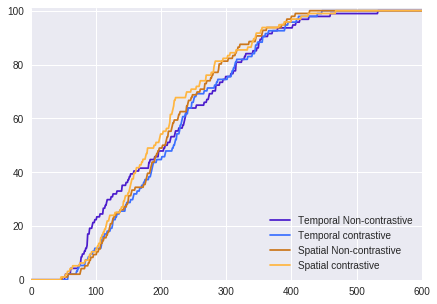

In [126]:
cp = attention_map_with_gaze.groupby(['Network', 'EBP Type', 'Clip']).median()['Gaze Distance']
fig, ax = plt.subplots(figsize=(7, 5))
plt_distance_cum(ax, cp.loc['Temporal']['Non-Contrastive'], label='Temporal Non-contrastive')
plt_distance_cum(ax, cp.loc['Temporal']['Contrastive'], label='Temporal contrastive')
plt_distance_cum(ax, cp.loc['Spatial']['Non-Contrastive'], label='Spatial Non-contrastive')
plt_distance_cum(ax, cp.loc['Spatial']['Contrastive'], label='Spatial contrastive')
plt.legend(loc='lower right')
plt.xlim(0, 600)

In [127]:
upper_limits = np.arange(0, max_dist, 1)
def count_under(row):
    return pd.DataFrame({
        'Upper Limit': upper_limits,
        'Count': list(map(lambda limit: count_distances_under_limit(row['Gaze Distance'], limit), upper_limits)),
    })

gaze_distances_by_action = pd.DataFrame()
gaze_distances_by_action = attention_map_with_gaze.groupby(['Network', 'EBP Type', 'Action']).apply(count_under)
gaze_distances_by_action.reset_index(inplace=True)
gaze_distances_by_action.head()

,Network,EBP Type,Action,level_3,Count,Upper Limit
0,Spatial,Contrastive,fill,0,0,0.0
1,Spatial,Contrastive,fill,1,0,1.0
2,Spatial,Contrastive,fill,2,0,2.0
3,Spatial,Contrastive,fill,3,0,3.0
4,Spatial,Contrastive,fill,4,0,4.0


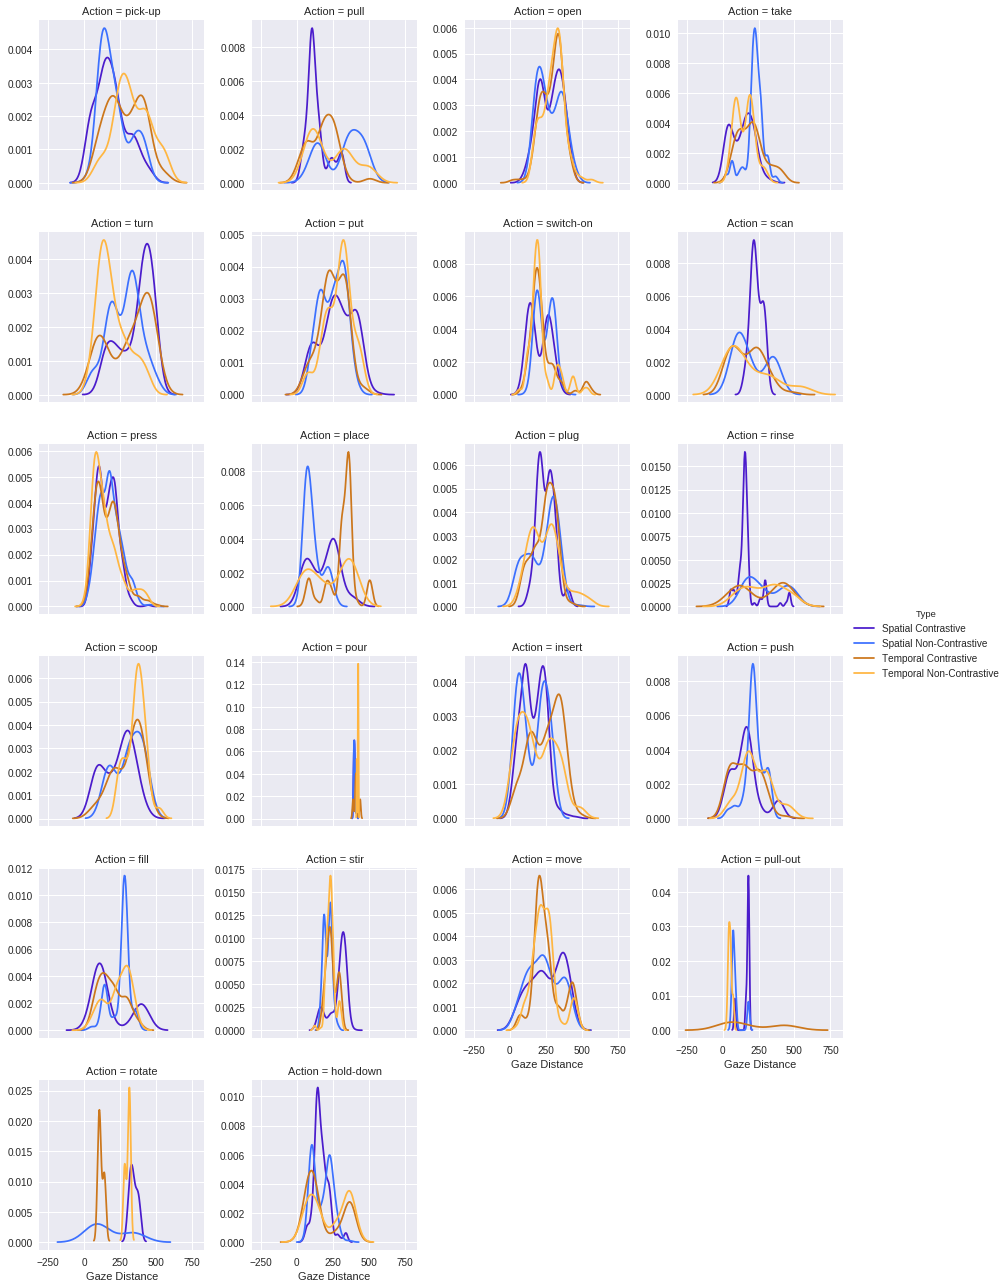

In [130]:
grid = sns.FacetGrid(attention_map_with_gaze,
                     col="Action", 
                     hue="Type",
                     sharey=False,
                     col_wrap=4)
grid.map(sns.distplot, "Gaze Distance", hist=False)
grid.add_legend()

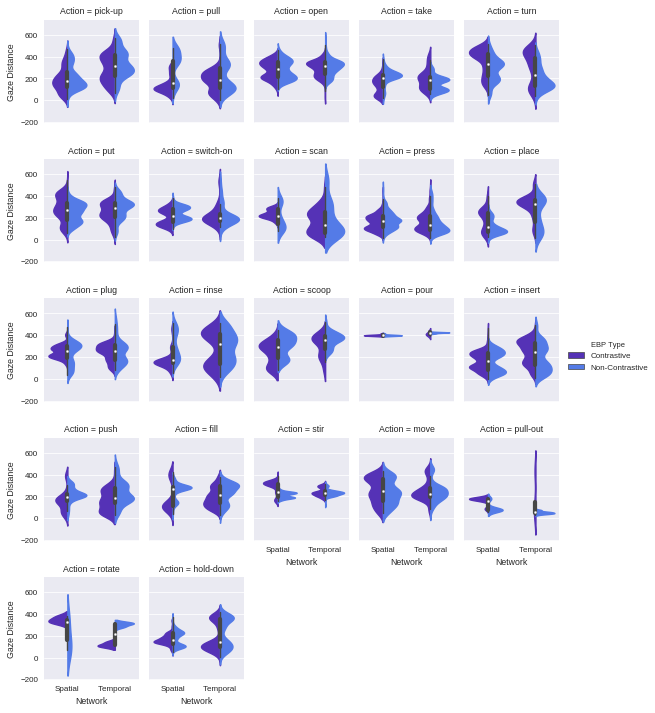

In [165]:
grid = sns.factorplot(x='Network',
               y='Gaze Distance', 
               col='Action',
               hue='EBP Type',
               col_wrap=5,
               kind='violin',
               size=2,
               aspect=0.8,
               split=True,
               legend=True,
               data=attention_map_with_gaze
              )

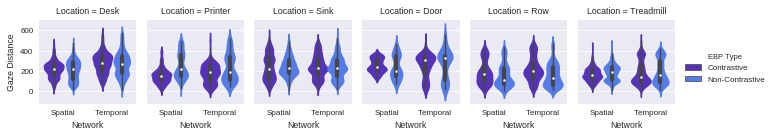

In [169]:
sns.factorplot(x='Network',
               y='Gaze Distance', 
               col="Location",
               hue='EBP Type',
               kind='violin',
               size=2,
               aspect=0.8,
               legend=True,
               data=attention_map_with_gaze
              )

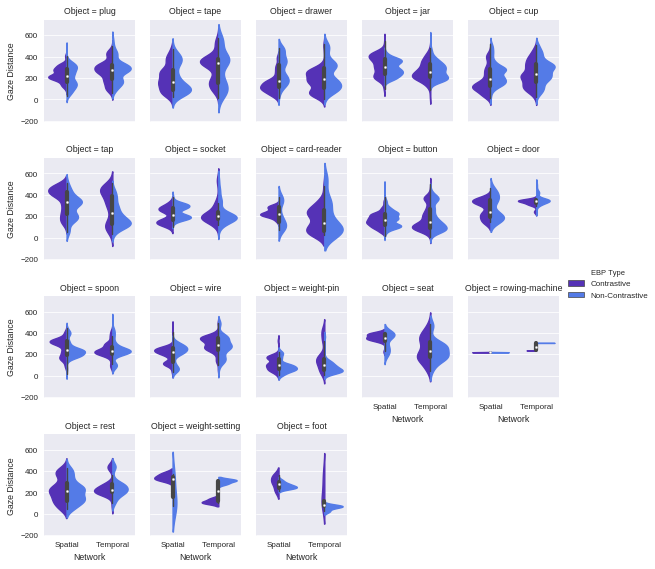

In [176]:
sns.factorplot(y='Gaze Distance', 
               x='Network',
               col="Object",
               col_wrap=5,
               hue='EBP Type',
               kind='violin',
               size=2,
               aspect=0.8,
               legend=True,
               legend_out=True,
               split=True,
               data=attention_map_with_gaze
              )

In [136]:
display_full(attention_map_with_gaze.groupby(['Network', 'EBP Type', 'Action']).count())

Attention Map  Frame  Clip  Window Size  \
Network  EBP Type        Action                                               
Spatial  Contrastive     fill                 120    120   120          120   
                         hold-down            505    505   505          505   
                         insert               373    373   373          373   
                         move                 159    159   159          159   
                         open                 158    158   158          158   
                         pick-up              198    198   198          198   
                         place                 72     72    72           72   
                         plug                 165    165   165          165   
                         pour                  14     14    14           14   
                         press                819    819   819          819   
                         pull                 138    138   138          138   
                         pull-out              35     35    35           35   
                         push                  80     80    80           80   
                         put                  180    180   180          180   
                         rinse                118    118   118          118   
                         rotate                 3      3     3            3   
                         scan                  50     50    50           50   
                         scoop                 49     49    49           49   
                         stir                 182    182   182          182   
                         switch-on             78     78    78           78   
                         take                 105    105   105          105   
                         turn                 157    157   157          157   
         Non-Contrastive fill                 120    120   120          120   
                         hold-down            505    505   505          505   
                         insert               373    373   373          373   
                         move                 159    159   159          159   
                         open                 158    158   158          158   
                         pick-up              198    198   198          198   
                         place                 72     72    72           72   
                         plug                 165    165   165          165   
                         pour                  14     14    14           14   
                         press                819    819   819          819   
                         pull                 138    138   138          138   
                         pull-out              35     35    35           35   
                         push                  80     80    80           80   
                         put                  180    180   180          180   
                         rinse                118    118   118          118   
                         rotate                 3      3     3            3   
                         scan                  50     50    50           50   
                         scoop                 49     49    49           49   
                         stir                 182    182   182          182   
                         switch-on             78     78    78           78   
                         take                 105    105   105          105   
                         turn                 157    157   157          157   
Temporal Contrastive     fill                 118    118   118          118   
                         hold-down            482    482   482          482   
                         insert               334    334   334          334   
                         move                 150    150   150          150   
                         open                 125    125   125          125   
       